In [1]:
from collections         import namedtuple
import json

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from slugify import slugify

In [2]:
Dist = namedtuple('Requests', ['raw', 'cdf'])


class Adblocker:
    def __init__(self, filename, color, label):
        self.label = label
        self.color = color
        self._raw = self.load_data(filename)
        
        self.cacheSize = self._raw['cacheSize']
        self.parsingTime = self._raw['parsingTime']

        serializationTimings = self._raw.get('serializationTimings')
        if serializationTimings:
            self.serializationTimings = Dist(
                raw=serializationTimings, 
                cdf=self.generateCDF(serializationTimings)
            )
            
        deserializationTimings = self._raw.get('deserializationTimings')
        if deserializationTimings:
            self.deserializationTimings = Dist(
                raw=deserializationTimings, 
                cdf=self.generateCDF(deserializationTimings)
            )


        # data
        self.blocked = Dist(raw=self._raw['matches'], cdf=self.generateCDF(self._raw['matches']))
        self.not_blocked = Dist(raw=self._raw['noMatches'], cdf=self.generateCDF(self._raw['noMatches']))
        self.all = Dist(raw=self._raw['all'], cdf=self.generateCDF(self._raw['all']))

    
    @staticmethod
    def load_data(filename):
        with open(filename, 'r') as f:
            return json.load(f)

    @staticmethod
    def generateCDF(array):
        cdf_attrs = namedtuple('cdf_attrs', ['cdf', 'bin_edges'])

        data_size=len(array)

        # Set bins edges
        data_set=sorted(set(array))
        bins=np.append(data_set, data_set[-1]+1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(array, bins=bins, density=False)
        counts = counts.astype(float) / data_size

        # Find the cdf
        _cdf = np.cumsum(counts)

        return cdf_attrs(cdf=_cdf, bin_edges=bin_edges)

In [3]:
brave  = Adblocker(filename='data/brave_timings.json', color='#ff5500', label='Brave')
cliqz  = Adblocker(filename='data/cliqz_timings.json', color='#00aff0', label='Cliqz')
ublock = Adblocker(filename='data/ublock_timings.json', color='#800000', label='uBlock Origin')
duck   = Adblocker(filename='data/duckduckgo_timings.json', color='#58b792', label='DuckDuckGo')
abp    = Adblocker(filename='data/adblockplus_timings.json', color='#c70d2c', label='AdblockPlus')

In [4]:
def compare(*args, attr='match', log_x=False, log_y=False, xlim=None, save=True):
    fig, ax = plt.subplots()
    
    for a in args:
        _attr = getattr(a, attr)
        ax.plot(_attr.cdf.bin_edges[0:-1], _attr.cdf.cdf, linestyle='--', linewidth=2, color=a.color, label=a.label)
        
    # Plot the cdf
    ax.grid(linestyle='--', linewidth=1)
    if xlim:
        ax.set_xlim(*xlim)
    ax.legend(loc='lower right')
    plt.tight_layout(pad=3)
    if log_x:
        plt.xscale('log')
        plt.xlabel("Time (ms) \n log (base 10)")
    else:
        plt.xlabel("Time (ms)")
    if log_y:
        plt.yscale('log')
        plt.ylabel("Fraction of Requests \n log (base 10)")
    else:
        plt.ylabel("Fraction of Requests")
    if save:
        filename = slugify(f'{"-".join(map(lambda x: x.label, args))}-{attr}')
        fig.savefig(f'plots/{filename}.svg')
    plt.show()

In [5]:
def pie(*args, save=True):    

    match = []
    no_match = []

    for a in args:
        match.append(len(a.blocked.raw))
        no_match.append(len(a.not_blocked.raw))

    sizes = [np.mean(match), np.mean(no_match)]
    labels = ['Blocked', 'Not Blocked']
    colors = ['#ff9999','#91c5f5']
    explode = (0.05, 0.05)
    plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')  
    plt.tight_layout()
    plt.show()
    fig.savefig('plots/requests-composition.svg')

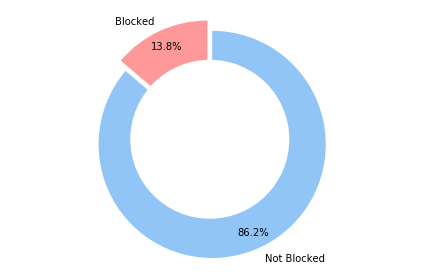

In [6]:
pie(cliqz, ublock, duck, brave, abp)

### **Looking at all requests**

#### 1. **Cliqz vs uBlock**

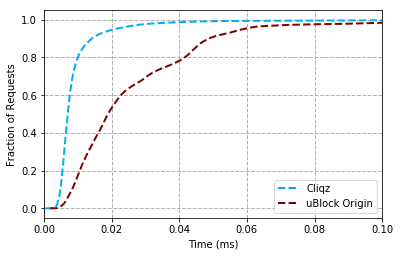

In [7]:
compare(cliqz, ublock, attr="all", log_x=False, log_y=False, xlim=(0, 0.10))

### **Cliqz vs uBlock vs Brave**

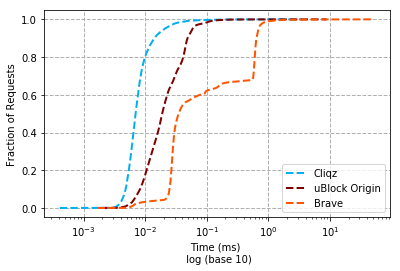

In [8]:
compare(cliqz, ublock, brave, attr="all", log_x=True, log_y=False)

### **Cliqz vs AdblockPlus**

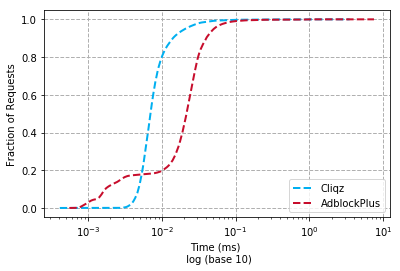

In [9]:
compare(cliqz, abp, attr="all", log_x=True, log_y=False)

### **Cliqz vs AdblockPlus vs uBlock Origin**

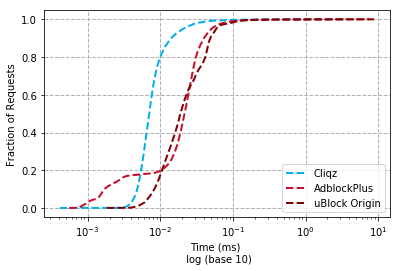

In [10]:
compare(cliqz, abp, ublock, attr="all", log_x=True, log_y=False)

### **Cliqz vs uBlock vs Brave vs DuckDuckGo**

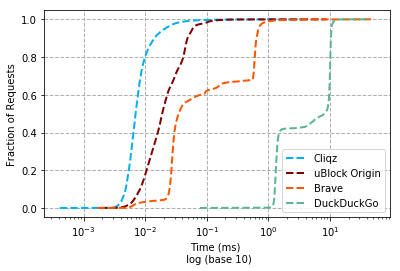

In [11]:
compare(cliqz, ublock, brave, duck, attr="all", log_x=True, log_y=False)

### **Cliqz vs uBlock vs Brave vs AdblockPlus**

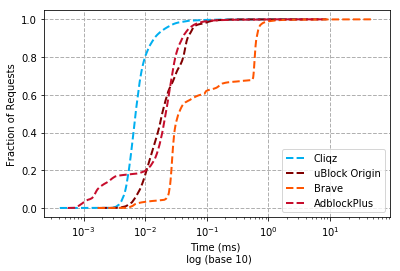

In [12]:
compare(cliqz, ublock, brave, abp, attr="all", log_x=True, log_y=False)

### **Cliqz vs uBlock vs AdblockPlus**

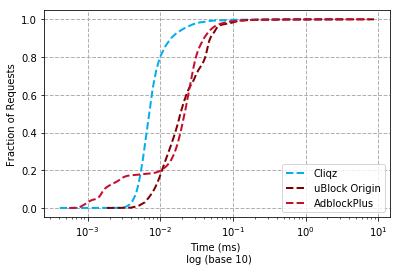

In [13]:
compare(cliqz, ublock, abp, attr="all", log_x=True, log_y=False)

### **What happens where there is a match**

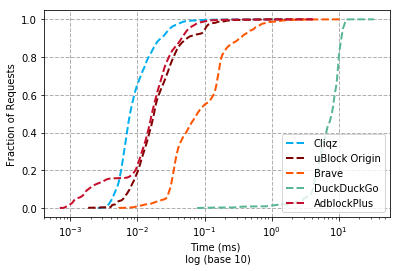

In [14]:
compare(cliqz, ublock, brave, duck, abp, attr="blocked", log_x=True, log_y=False,)

### **What happens where there is NO match**

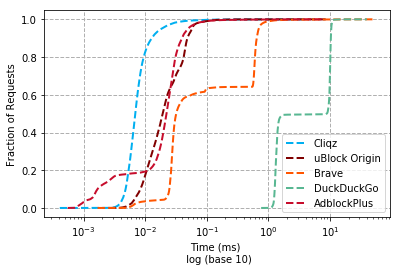

In [15]:
compare(cliqz, ublock, brave, duck, abp, attr="not_blocked", log_x=True, log_y=False)

### Memory

### 99th percentile

In [16]:
def get_99p(adblocker):
    return [
        adblocker.all.cdf.bin_edges[len([x for x in adblocker.all.cdf.cdf if x < 0.99])],
        adblocker.not_blocked.cdf.bin_edges[len([x for x in adblocker.not_blocked.cdf.cdf if x < 0.99])],
        adblocker.blocked.cdf.bin_edges[len([x for x in adblocker.blocked.cdf.cdf if x < 0.99])],
    ]

p99 = pd.DataFrame({
    'request_type': ['_all', 'not_blocked', 'blocked'],
    'cliqz': get_99p(cliqz),
    'ublock': get_99p(ublock),
    'brave': get_99p(brave),
    'duck': get_99p(duck),
    'abp': get_99p(abp),
})

p99['ublock_vs_cliqz'] = p99.ublock / p99.cliqz
p99['brave_vs_cliqz'] = p99.brave / p99.cliqz
p99['duck_vs_cliqz'] = p99.duck / p99.cliqz
p99['abp_vs_cliqz'] = p99.abp / p99.cliqz

In [17]:
p99

,request_type,cliqz,ublock,brave,duck,abp,ublock_vs_cliqz,brave_vs_cliqz,duck_vs_cliqz,abp_vs_cliqz
0,_all,0.044645,0.113217,1.019382,11.537244,0.098190,2.535939,22.833061,258.421861,2.199350
1,not_blocked,0.041697,0.097461,1.004570,10.808763,0.096755,2.337362,24.092141,259.221599,2.320431
2,blocked,0.051245,0.201451,1.247309,12.599570,0.102805,3.931135,24.340111,245.869256,2.006147


### Medians

In [18]:
medians = pd.DataFrame({
    'request_type': ['_all', 'not_blocked', 'blocked'],
    'cliqz': list(map(lambda x: np.median(x), [cliqz.all.raw, cliqz.not_blocked.raw, cliqz.blocked.raw])),
    'ublock': list(map(lambda x: np.median(x), [ublock.all.raw, ublock.not_blocked.raw, ublock.blocked.raw])),
    'brave': list(map(lambda x: np.median(x), [brave.all.raw, brave.not_blocked.raw, brave.blocked.raw])),
    'duck': list(map(lambda x: np.median(x), [duck.all.raw, duck.not_blocked.raw, duck.blocked.raw])),
    'abp': list(map(lambda x: np.median(x), [abp.all.raw, abp.not_blocked.raw, abp.blocked.raw]))

})


In [19]:
medians['ublock_vs_cliqz'] = medians.ublock / medians.cliqz
medians['brave_vs_cliqz'] = medians.brave / medians.cliqz
medians['duck_vs_cliqz'] = medians.duck / medians.cliqz
medians['abp_vs_cliqz'] = medians.abp / medians.cliqz

In [20]:
medians

,request_type,cliqz,ublock,brave,duck,abp,ublock_vs_cliqz,brave_vs_cliqz,duck_vs_cliqz,abp_vs_cliqz
0,_all,0.006997,0.018883,0.034930,8.103691,0.021592,2.698728,4.992139,1158.166500,3.085894
1,not_blocked,0.006913,0.019156,0.031946,8.862395,0.022205,2.771011,4.621149,1281.989802,3.212064
2,blocked,0.007741,0.017626,0.077872,7.907921,0.016364,2.276967,10.059682,1021.563170,2.113939


## Serialization and Deserialization timings

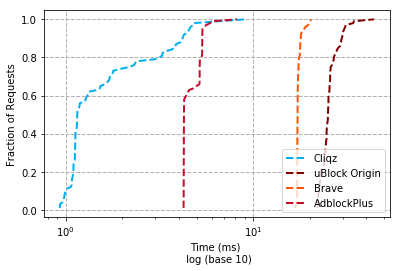

In [21]:
compare(cliqz, ublock, brave, abp, attr="serializationTimings", log_x=True, log_y=False)

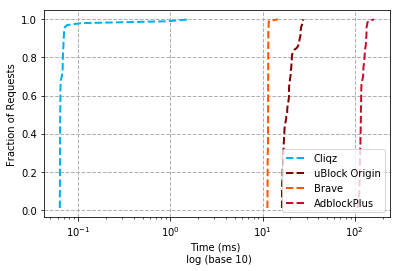

In [22]:
compare(cliqz, ublock, brave, abp, attr="deserializationTimings", log_x=True, log_y=False)

In [23]:
# simplified bar plot of medians

In [24]:
loading_medians = pd.DataFrame({
    'adblocker': ['Cliqz', 'uBlock Origin', 'Brave', 'AdblockPlus'],
    'deserialization': list(map(lambda x: np.median(x.raw), [cliqz.deserializationTimings, ublock.deserializationTimings, brave.deserializationTimings, abp.deserializationTimings])),
    'serialization': list(map(lambda x: np.median(x.raw), [cliqz.serializationTimings, ublock.serializationTimings, brave.serializationTimings, abp.serializationTimings]))
})

In [25]:
def barplot(df, metric, ylabel, color, save=True):
    fig, ax = plt.subplots()
    plt.bar(x = df.adblocker, height=df[metric], width=0.5, color=color)
            
    # Plot the cdf
    ax.grid(linestyle='--', linewidth=1)

    plt.tight_layout(pad=3)
    plt.ylabel(ylabel)
    plt.title(f'{metric.title()}')
    if save:
        fig.savefig(f'plots/{slugify(metric)}.svg')
    plt.show()

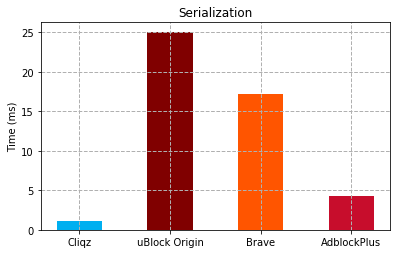

In [26]:
barplot(
    loading_medians, 
    'serialization', 
    ylabel="Time (ms)", 
    color=[cliqz.color, ublock.color, brave.color, abp.color], 
    save=True
)

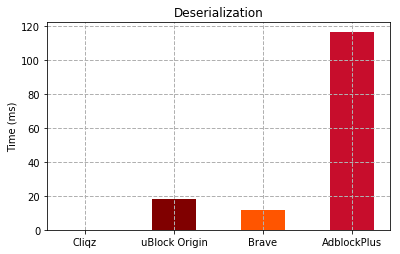

In [27]:
barplot( 
    loading_medians, 
    'deserialization', 
    ylabel="Time (ms)", 
    color=[cliqz.color, ublock.color, brave.color, abp.color], 
    save=True
)

## Serialized Size

In [28]:
size_medians = pd.DataFrame({
    'adblocker': ['AdblockPlus', 'Cliqz', 'uBlock Origin', 'Brave'],
    'Cache Size': [abp.cacheSize, cliqz.cacheSize, ublock.cacheSize, brave.cacheSize]
})

size_medians['Cache Size'] /= (10**6)

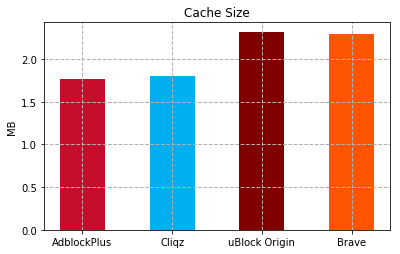

In [29]:
barplot(
    size_medians, 
    'Cache Size', 
    ylabel="MB", 
    color=[abp.color, cliqz.color, ublock.color, brave.color], 
    save=True
)

### Memory Usage

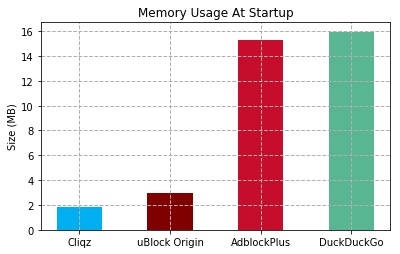

In [30]:
memory_medians = pd.DataFrame({
    'adblocker': ['Cliqz', 'uBlock Origin', 'AdblockPlus', 'DuckDuckGo'],
    'Memory Usage at startup': [1.803, 2.942, 15.292, 15.920]
})


barplot(
    memory_medians, 
    'Memory Usage at startup', 
    ylabel="Size (MB)", 
    color=[cliqz.color, ublock.color, abp.color, duck.color], 
    save=True
)

### Time to Parse Lists

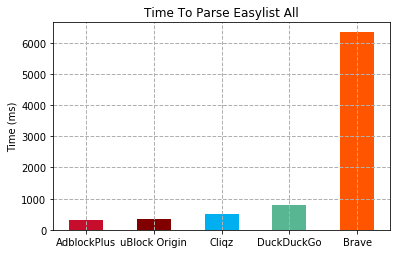

In [31]:
time2parse_medians = pd.DataFrame({
    'adblocker': ['AdblockPlus', 'uBlock Origin', 'Cliqz', 'DuckDuckGo', 'Brave'],
    'Time to parse Easylist All': [abp.parsingTime, ublock.parsingTime, cliqz.parsingTime, duck.parsingTime, brave.parsingTime]
})

barplot(
    time2parse_medians, 
    'Time to parse Easylist All', 
    ylabel="Time (ms)", 
    color=[abp.color, ublock.color, cliqz.color, duck.color, brave.color], 
    save=True
)

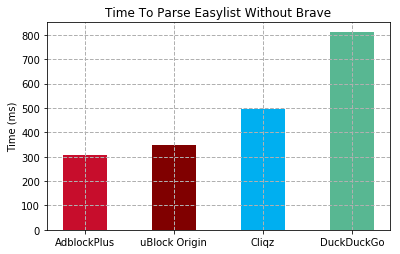

In [32]:
time2parse_medians = pd.DataFrame({
    'adblocker': ['AdblockPlus', 'uBlock Origin', 'Cliqz', 'DuckDuckGo'],
    'Time to parse Easylist Without Brave': [abp.parsingTime, ublock.parsingTime, cliqz.parsingTime, duck.parsingTime]
})

barplot(
    time2parse_medians, 
    'Time to parse Easylist Without Brave', 
    ylabel="Time (ms)", 
    color=[abp.color, ublock.color, cliqz.color, duck.color], 
    save=True
)